In [1]:
import itertools
import os
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm
import copy
import seaborn as sns

from utils import *
from lag_test_utils import *
from scipy.optimize import root_scalar

import matplotlib as mpl
import pandas as pd
import multiprocessing

# Set the default font and size
# mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

import matplotlib.colors as mcolors
def interpolate_colors(color1, color2, k):
    """Generate a list of colors interpolating between two hex colors."""
    rgb1 = mcolors.hex2color(color1)
    rgb2 = mcolors.hex2color(color2)
    # Interpolate colors
    interpolated_colors = [
        mcolors.to_hex([(1 - t) * c1 + t * c2 for c1, c2 in zip(rgb1, rgb2)])
        for t in [i / (k - 1) for i in range(k)]
    ]
    return interpolated_colors

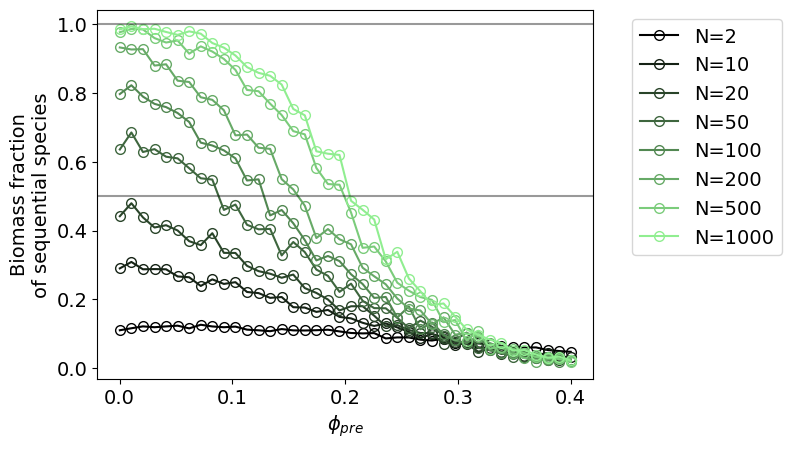

In [4]:
import pickle
import matplotlib.colors as mcolors
def generate_color_gradient(start_color, end_color, n):
    start_rgb = mcolors.hex2color(start_color)
    end_rgb = mcolors.hex2color(end_color)
    gradient = [mcolors.rgb2hex([start_rgb[j] + i * (end_rgb[j] - start_rgb[j]) / (n - 1) for j in range(3)]) for i in range(n)]
    return gradient

pool_size = 100
n_rho=40
pool_size_list = [2, 10, 20, 50, 100, 200, 500, 1000]
color_list = generate_color_gradient("#000000", "#90EE90", len(pool_size_list))

for idx, pool_size in enumerate(pool_size_list):
    fracs = []
    rholist = np.linspace(1e-4, 0.4, n_rho)
    for rho in rholist:
        data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_size={pool_size}.pkl", "rb"))["data"]
        # all_ids = []
        # for i in data:
        #     all_ids.extend(i[0][1]["ids"])
        # fracs.append(len([i for i in all_ids if i<pool_size/2])/len(all_ids))
        fracs_phi = []
        for i in data:
            # get the fraction of biomass of the sequential species
            ids = i[0][1]["ids"]
            bs = i[0][1]["bs"][-1]
            fracs_phi.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
        fracs.append(np.mean(fracs_phi))
    plt.plot(rholist, fracs, markerfacecolor='none', color=color_list[idx], marker='o', markersize=7, label=f"N={pool_size}")
plt.xlabel("$\\phi_{pre}$")
plt.ylabel("Biomass fraction\nof sequential species")
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1))
plt.axhline(1.0, color="k", alpha=0.4)
plt.axhline(0.5, color="k", alpha=0.4)
# plt.xscale("log")
plt.savefig("figs1.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_476255/3225626216.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([5, 4, 3, 2, 1, 0])


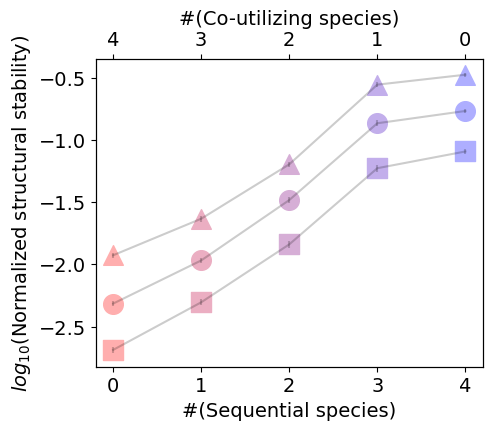

/tmp/ipykernel_476255/3225626216.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([5, 4, 3, 2, 1, 0])


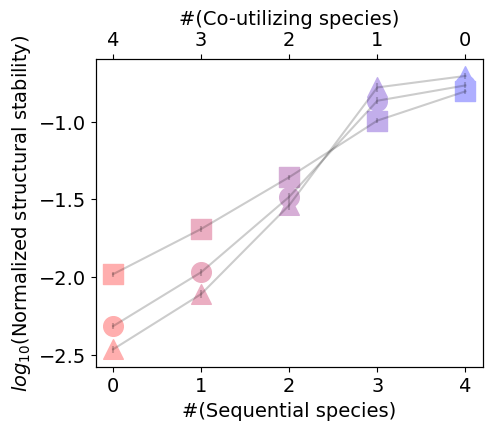

/tmp/ipykernel_476255/3225626216.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([5, 4, 3, 2, 1, 0])


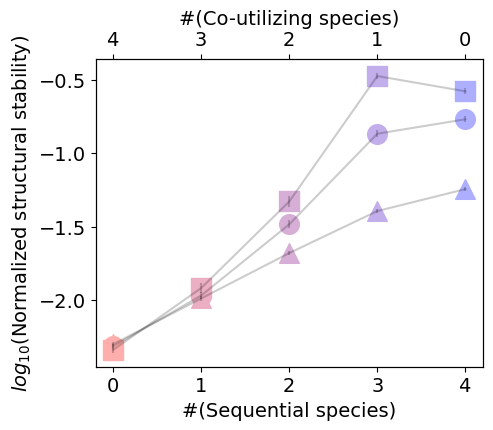

In [18]:
parameters_list = [[100, 0.1, lambda x: np.random.uniform(0.2, 0.4)], 
                   [10000, 0.1, lambda x: np.random.uniform(0.2, 0.4)], 
                   [1000, 0.075, lambda x: np.random.uniform(0.2, 0.4)], 
                   [1000, 0.2, lambda x: np.random.uniform(0.2, 0.4)], 
                   [1000, 0.1, lambda x: np.random.uniform(0, 0)], 
                   [1000, 0.1, lambda x: np.random.uniform(0.05, 0.1)], 
                   [1000, 0.1, lambda x: np.random.uniform(0.4, 0.8)]]

# first it's about these stability data. 
default = pickle.load(open("stability_dist_main.pkl", "rb"))

# dilution rate
data = []
param_idx = [0, 1]
for idx in param_idx:
    all_stabilities = []
    for Nseq in [0, 1, 2, 3, 4]:
        all_stabilities.append(pickle.load(open(f"stabilities_Nseq={Nseq}_parameters={idx}.pkl", "rb")))
    data.append(all_stabilities)
data = [data[0], default, data[1]]
        
plt.rcParams["figure.figsize"] = (5,4)
fig, ax1 = plt.subplots()
marker_list = ["^", "o", "s"]
colors = interpolate_colors("#ffaeae", "#aeaeff", 5)
for d_idx, d in enumerate(data):
    all_stabilities = d
    ax1.errorbar(range(5), [np.mean(i) for i in all_stabilities], yerr=[np.std(i)/sqrt(len(i)) for i in all_stabilities], color="k", alpha=0.2)
    for idx, i in enumerate(all_stabilities):
        ax1.scatter([idx], np.mean(i), color=colors[idx], marker=marker_list[d_idx], s=200)
ax1.set_xticks([0, 1, 2, 3, 4])
ax1.set_xlabel("#(Sequential species)")
ax1.set_ylabel("$log_{10}$"+"(Normalized structural stability)")
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("#(Co-utilizing species)")
ax2.set_xticklabels([5, 4, 3, 2, 1, 0])
plt.savefig("figs2-1.pdf", bbox_inches="tight")
plt.show()

# gsigma
data = []
param_idx = [2, 3]
for idx in param_idx:
    all_stabilities = []
    for Nseq in [0, 1, 2, 3, 4]:
        all_stabilities.append(pickle.load(open(f"stabilities_Nseq={Nseq}_parameters={idx}.pkl", "rb")))
    data.append(all_stabilities)
data = [data[0], default, data[1]]
        
plt.rcParams["figure.figsize"] = (5,4)
fig, ax1 = plt.subplots()
marker_list = ["^", "o", "s"]
colors = interpolate_colors("#ffaeae", "#aeaeff", 5)
for d_idx, d in enumerate(data):
    all_stabilities = d
    ax1.errorbar(range(5), [np.mean(i) for i in all_stabilities], yerr=[np.std(i)/sqrt(len(i)) for i in all_stabilities], color="k", alpha=0.2)
    for idx, i in enumerate(all_stabilities):
        ax1.scatter([idx], np.mean(i), color=colors[idx], marker=marker_list[d_idx], s=200)
ax1.set_xticks([0, 1, 2, 3, 4])
ax1.set_xlabel("#(Sequential species)")
ax1.set_ylabel("$log_{10}$"+"(Normalized structural stability)")
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("#(Co-utilizing species)")
ax2.set_xticklabels([5, 4, 3, 2, 1, 0])
plt.savefig("figs3-1.pdf", bbox_inches="tight")
plt.show()

# lag-time
data = []
param_idx = [5, 6]
for idx in param_idx:
    all_stabilities = []
    for Nseq in [0, 1, 2, 3, 4]:
        all_stabilities.append(pickle.load(open(f"stabilities_Nseq={Nseq}_parameters={idx}.pkl", "rb")))
    data.append(all_stabilities)
data = [data[0], default, data[1]]
        
plt.rcParams["figure.figsize"] = (5,4)
fig, ax1 = plt.subplots()
marker_list = ["^", "o", "s"]
colors = interpolate_colors("#ffaeae", "#aeaeff", 5)
for d_idx, d in enumerate(data):
    all_stabilities = d
    ax1.errorbar(range(5), [np.mean(i) for i in all_stabilities], yerr=[np.std(i)/sqrt(len(i)) for i in all_stabilities], color="k", alpha=0.2)
    for idx, i in enumerate(all_stabilities):
        ax1.scatter([idx], np.mean(i), color=colors[idx], marker=marker_list[d_idx], s=200)
ax1.set_xticks([0, 1, 2, 3, 4])
ax1.set_xlabel("#(Sequential species)")
ax1.set_ylabel("$log_{10}$"+"(Normalized structural stability)")
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("#(Co-utilizing species)")
ax2.set_xticklabels([5, 4, 3, 2, 1, 0])
plt.savefig("figs4-1.pdf", bbox_inches="tight")
plt.show()

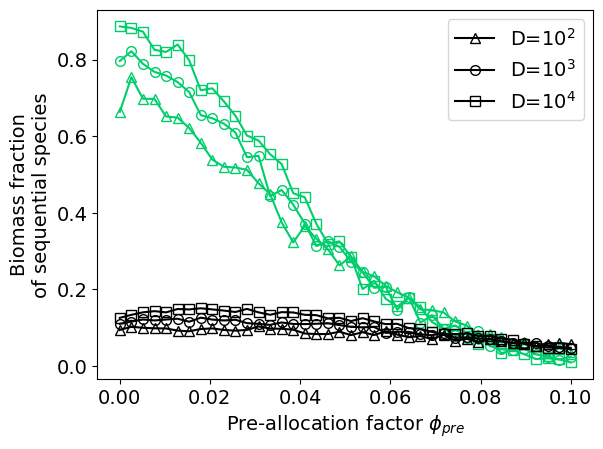

In [6]:
# redo the parts for varied rho
parameters_list = [[100, 0.1, lambda x: np.random.uniform(0.2, 0.4)], 
                   [10000, 0.1, lambda x: np.random.uniform(0.2, 0.4)], 
                   [1000, 0.075, lambda x: np.random.uniform(0.2, 0.4)], 
                   [1000, 0.2, lambda x: np.random.uniform(0.2, 0.4)], 
                   [1000, 0.1, lambda x: np.random.uniform(0, 0)], 
                   [1000, 0.1, lambda x: np.random.uniform(0.05, 0.1)], 
                   [1000, 0.1, lambda x: np.random.uniform(0.4, 0.8)]]
n_rho=40
rholist = np.linspace(1e-4, 0.4, n_rho)

# default
# head-to-head
pool_size=2
fracs = []
rholist = np.linspace(1e-4, 0.4, n_rho)
for rho in rholist:
    data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_size={pool_size}.pkl", "rb"))["data"]
    fracs_phi = []
    for i in data:
        # get the fraction of biomass of the sequential species
        ids = i[0][1]["ids"]
        bs = i[0][1]["bs"][-1]
        fracs_phi.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
    fracs.append(np.mean(fracs_phi))
fracs_2_default = fracs
# in community
pool_size = 100
fracs = []
rholist = np.linspace(1e-4, 0.4, n_rho)
for rho in rholist:
    data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_size={pool_size}.pkl", "rb"))["data"]
    fracs_phi = []
    for i in data:
        # get the fraction of biomass of the sequential species
        ids = i[0][1]["ids"]
        bs = i[0][1]["bs"][-1]
        fracs_phi.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
    fracs.append(np.mean(fracs_phi))
fracs_100_default = fracs

marker_list = ["^", "o", "s"]

# dilution factor
param_idx = [0, 1]
pool_size=100
Dlist = ["$10^2$", "$10^3$", "$10^4$"]
all_fracs = []
for idx in param_idx:
    fracs = []
    rholist = np.linspace(1e-4, 0.4, n_rho)
    for rho in rholist:
        data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_parameters={idx}.pkl", "rb"))["data"]
        fracs_phi = []
        for i in data:
            # get the fraction of biomass of the sequential species
            ids = i[0][1]["ids"]
            bs = i[0][1]["bs"][-1]
            fracs_phi.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
        fracs.append(np.mean(fracs_phi))
    all_fracs.append(fracs)
all_fracs = [all_fracs[0], fracs_100_default, all_fracs[1]]
for idx, i in enumerate(all_fracs):
    plt.plot(rholist/4, i, markerfacecolor='none', color="#00CD6C", marker=marker_list[idx], markersize=7)

pool_size=2
all_fracs = []
for idx in param_idx:
    fracs = []
    rholist = np.linspace(1e-4, 0.4, n_rho)
    for rho in rholist:
        data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_parameters={idx}_pairwise.pkl", "rb"))["data"]
        fracs_phi = []
        for i in data:
            # get the fraction of biomass of the sequential species
            ids = i[0][1]["ids"]
            bs = i[0][1]["bs"][-1]
            fracs_phi.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
        fracs.append(np.mean(fracs_phi))
    all_fracs.append(fracs)
all_fracs = [all_fracs[0], fracs_2_default, all_fracs[1]]
for idx, i in enumerate(all_fracs):
    plt.plot(rholist/4, i, markerfacecolor='none', color="k", marker=marker_list[idx], markersize=7, label=f"D={Dlist[idx]}")
    
plt.xlabel("Pre-allocation factor $\\phi_{pre}$")
plt.ylabel("Biomass fraction\nof sequential species")
plt.legend()
plt.savefig("figs2-2.pdf", bbox_inches="tight")
plt.show()

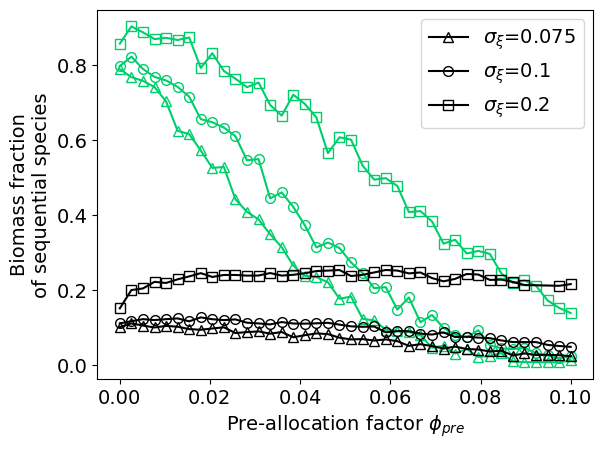

In [28]:
# gsigma
param_idx = [2, 3]
pool_size=100
all_fracs = []
slist = [0.075, 0.1, 0.2]
for idx in param_idx:
    fracs = []
    rholist = np.linspace(1e-4, 0.4, n_rho)
    for rho in rholist:
        data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_parameters={idx}.pkl", "rb"))["data"]
        fracs_phi = []
        for i in data:
            # get the fraction of biomass of the sequential species
            ids = i[0][1]["ids"]
            bs = i[0][1]["bs"][-1]
            fracs_phi.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
        fracs.append(np.mean(fracs_phi))
    all_fracs.append(fracs)
all_fracs = [all_fracs[0], fracs_100_default, all_fracs[1]]
for idx, i in enumerate(all_fracs):
    plt.plot(rholist/4, i, markerfacecolor='none', color="#00CD6C", marker=marker_list[idx], markersize=7)

pool_size=2
all_fracs = []
slist = [0.075, 0.1, 0.2]
all_xs = []
for idx in param_idx:
    fracs = []
    xs = []
    rholist = np.linspace(1e-4, 0.4, n_rho)
    for rho in rholist:
        if(os.path.exists(f"../data/seq_vs_co_lag_new/rho={rho}_parameters={idx}_pairwise.pkl")):
            data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_parameters={idx}_pairwise.pkl", "rb"))["data"]
            fracs_phi = []
            for i in data:
                # get the fraction of biomass of the sequential species
                ids = i[0][1]["ids"]
                bs = i[0][1]["bs"][-1]
                fracs_phi.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
            fracs.append(np.mean(fracs_phi))
            xs.append(rho/4)
    all_fracs.append(fracs)
    all_xs.append(xs)
all_fracs = [all_fracs[0], fracs_2_default, all_fracs[1]]
all_xs = [all_xs[0], rholist/4, all_xs[1]]
for idx, i in enumerate(all_fracs):
    plt.plot(all_xs[idx], i, markerfacecolor='none', color="k", marker=marker_list[idx], markersize=7, label=f"$\\sigma_\\xi$={slist[idx]}")


plt.xlabel("Pre-allocation factor $\\phi_{pre}$")
plt.ylabel("Biomass fraction\nof sequential species")
plt.legend()
plt.savefig("figs3-2.pdf", bbox_inches="tight")
plt.show()

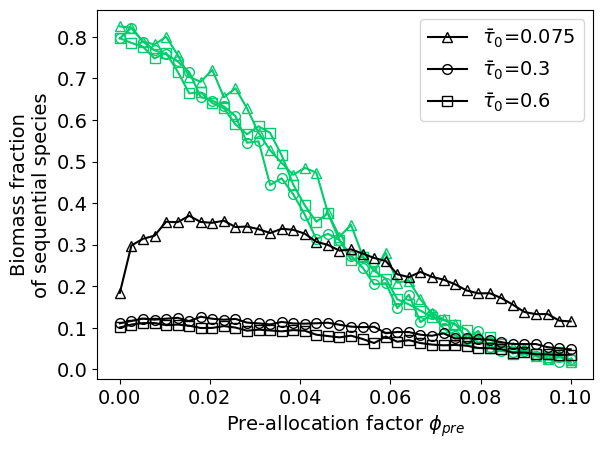

In [8]:
# tau
marker_list = ["^", "o", "s"]
param_idx = [5, 6]
all_fracs = []
pool_size = 100
taulist = [0.075, 0.3, 0.6]
for idx in param_idx:
    fracs = []
    rholist = np.linspace(1e-4, 0.4, n_rho)
    for rho in rholist:
        data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_parameters={idx}.pkl", "rb"))["data"]
        fracs_phi = []
        for i in data:
            # get the fraction of biomass of the sequential species
            ids = i[0][1]["ids"]
            bs = i[0][1]["bs"][-1]
            fracs_phi.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
        fracs.append(np.mean(fracs_phi))
    all_fracs.append(fracs)
all_fracs = [all_fracs[0], fracs_100_default, all_fracs[1]]
# all_fracs = [fracs_100_default, all_fracs[1]]
for idx, i in enumerate(all_fracs):
    plt.plot(rholist/4, i, markerfacecolor='none', color="#00CD6C", marker=marker_list[idx], markersize=7)

all_fracs = []
pool_size=2
taulist = [0.075, 0.3, 0.6]
for idx in param_idx:
    fracs = []
    rholist = np.linspace(1e-4, 0.4, n_rho)
    for rho in rholist:
        data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_parameters={idx}_pairwise.pkl", "rb"))["data"]
        fracs_phi = []
        for i in data:
            # get the fraction of biomass of the sequential species
            ids = i[0][1]["ids"]
            bs = i[0][1]["bs"][-1]
            fracs_phi.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
        fracs.append(np.mean(fracs_phi))
    all_fracs.append(fracs)
all_fracs = [all_fracs[0], fracs_2_default, all_fracs[1]]
# all_fracs = [fracs_2_default, all_fracs[1]]
for idx, i in enumerate(all_fracs):
    plt.plot(rholist/4, i, markerfacecolor='none', color="k", marker=marker_list[idx], markersize=7, label="$\\bar{\\tau}_0$"+f"={taulist[idx]}")

plt.xlabel("Pre-allocation factor $\\phi_{pre}$")
plt.ylabel("Biomass fraction\nof sequential species")
plt.legend()
plt.savefig("figs4-2.pdf", bbox_inches="tight")
plt.show()

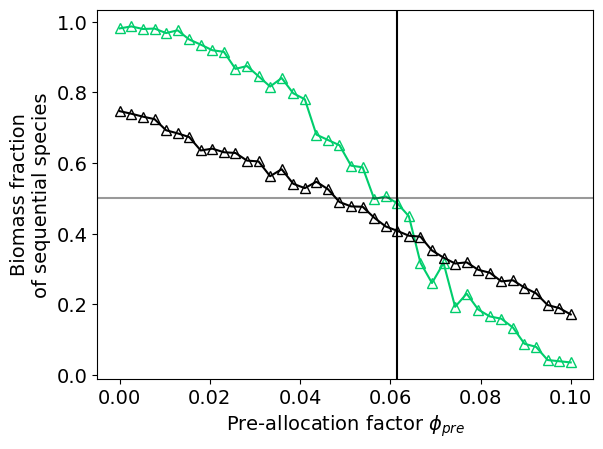

In [3]:
# tau
n_rho=40
param_idx = [4]
all_fracs = []
pool_size = 100
taulist = [0]
marker_list = ["^"]
for idx in param_idx:
    fracs = []
    rholist = np.linspace(1e-4, 0.4, n_rho)
    for rho in rholist:
        data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_parameters={idx}.pkl", "rb"))["data"]
        fracs_phi = []
        for i in data:
            # get the fraction of biomass of the sequential species
            ids = i[0][1]["ids"]
            bs = i[0][1]["bs"][-1]
            fracs_phi.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
        fracs.append(np.mean(fracs_phi))
    all_fracs.append(fracs)
for idx, i in enumerate(all_fracs):
    plt.plot(rholist/4, i, markerfacecolor='none', color="#00CD6C", marker=marker_list[idx], markersize=7)

all_fracs = []
pool_size=2
taulist = [0]
for idx in param_idx:
    fracs = []
    rholist = np.linspace(1e-4, 0.4, n_rho)
    for rho in rholist:
        data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_parameters={idx}_pairwise.pkl", "rb"))["data"]
        fracs_phi = []
        for i in data:
            # get the fraction of biomass of the sequential species
            ids = i[0][1]["ids"]
            bs = i[0][1]["bs"][-1]
            fracs_phi.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
        fracs.append(np.mean(fracs_phi))
    all_fracs.append(fracs)
for idx, i in enumerate(all_fracs):
    plt.plot(rholist/4, i, markerfacecolor='none', color="k", marker=marker_list[idx], markersize=7, label="$\\bar{\\tau}_0$"+f"={taulist[idx]}")

plt.xlabel("Pre-allocation factor $\\phi_{pre}$")
plt.ylabel("Biomass fraction\nof sequential species")
plt.axhline(0.5, color="k", alpha=0.4)
plt.axvline(rholist[24]/4, color="k")
plt.savefig("figs5-1.pdf", bbox_inches="tight")
plt.show()

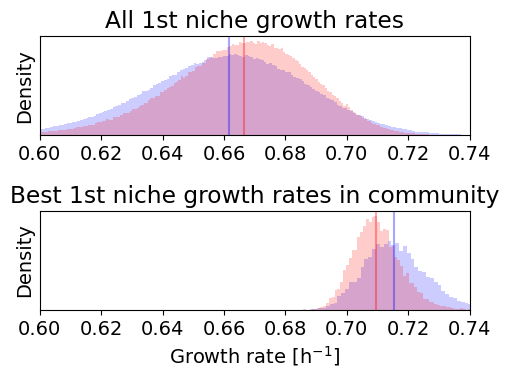

In [5]:
gC = 1
Nsamples = 10000
Npool = 50
R = 4

fig, axs = plt.subplots(2, 1, figsize=(5, 4))

g_diauxs_all = []
g_diauxs_max = []
g_couts_all = []
g_couts_max = []
rho = rholist[24]
for i in range(Nsamples):
    g1 = generate_g(Npool, R)
    g2 = generate_g(Npool, R)
    gt_1 = (rho+(1-rho)*R)*np.max(g1, axis=1)
    gt_2 = np.sum(g2, axis=1)+rho-rho
    g_diauxs_all.extend(list(1/(1/gt_1+1/gC)))
    g_couts_all.extend(list(1/(1/gt_2+1/gC)))
    g_diauxs_max.append(np.max(1/(1/gt_1+1/gC)))
    g_couts_max.append(np.max(1/(1/gt_2+1/gC)))
sns.histplot(g_diauxs_all, ax=axs[0], color="b", alpha = 0.2, stat="density", edgecolor="none", label="Sequential")
sns.histplot(g_couts_all, ax=axs[0], color="r", alpha = 0.2, stat="density", edgecolor="none", label="Coutilizing")
axs[0].axvline(np.median(g_diauxs_all), color="b", alpha=0.35)
axs[0].axvline(np.median(g_couts_all), color="r", alpha=0.35)
axs[0].set_xlim(0.60, 0.74)
axs[0].set_yticks([])
axs[0].set_yticklabels([])
# axs[0].set_xticks([0.6, 0.65, 0.7, 0.75])
axs[0].set_title("All 1st niche growth rates")
# axs[0].set_yscale("log")

sns.histplot(g_diauxs_max, ax=axs[1], color="b", alpha = 0.2, stat="density", edgecolor="none", label="Sequential")
sns.histplot(g_couts_max, ax=axs[1], color="r", alpha = 0.2, stat="density", edgecolor="none", label="Coutilizing")
axs[1].axvline(np.median(g_diauxs_max), color="b", alpha=0.35)
axs[1].axvline(np.median(g_couts_max), color="r", alpha=0.35)
axs[1].set_xlim(0.60, 0.74)
axs[1].set_xlabel("Growth rate [h$^{-1}$]")
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_title("Best 1st niche growth rates in community")

fig.tight_layout()
plt.savefig("figs5-2.pdf", bbox_inches="tight")

In [7]:
# fitness comparison without lags
n_rho = 40
D = 1000
rholist = np.linspace(1e-4, 0.4, n_rho)
Npairs = [(0, 1), (1, 0), (4, 0), (0, 4)]
all_t_deps = {Npair:[] for Npair in Npairs}
for Npair in Npairs:
    for rho in tqdm(rholist):
        all_t_deps[Npair].append([])
        data = pickle.load(open(f"../data/seq_vs_co_lag_new/fitness_rho={rho}_Npair={Npair}_nolag.pkl", "rb"))
        all_t_deps[Npair][-1] = [log(D)/i["ts"][-2] for i in data]

100%|██████████| 40/40 [00:00<00:00, 120.63it/s]


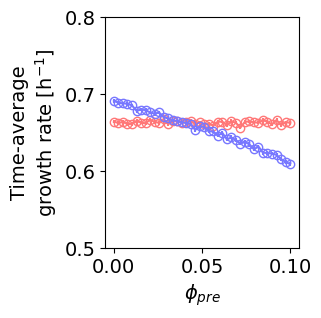

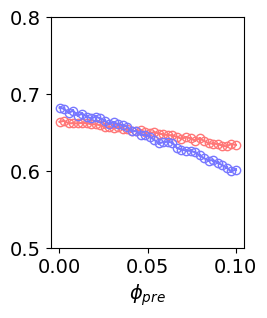

In [8]:
fig, ax = plt.subplots(figsize=(2.5, 3))
plt.errorbar(rholist/4, [np.mean(i) for i in all_t_deps[(0, 1)]], yerr=[np.std(i)/sqrt(len(i)) for i in all_t_deps[(0, 1)]], marker="o", 
             color="#ff7777", markerfacecolor='none', alpha=1, label="Coutilizing, single")
plt.errorbar(rholist/4, [np.mean(i) for i in all_t_deps[(1, 0)]], yerr=[np.std(i)/sqrt(len(i)) for i in all_t_deps[(1, 0)]], marker="o", 
             color="#7777ff", markerfacecolor='none', alpha=1, label="Sequential, single")
plt.xlabel("$\\phi_{pre}$")
plt.ylabel("Time-average\ngrowth rate [h$^{-1}$]")
plt.ylim(0.5, 0.8)
plt.savefig("figs5-3.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(2.5, 3))
plt.errorbar(rholist/4, [np.mean(i) for i in all_t_deps[(0, 4)]], yerr=[np.std(i)/sqrt(len(i)) for i in all_t_deps[(0, 4)]], marker="o", 
             color="#ff7777", markerfacecolor='none', alpha=1, label="Coutilizing, community")
plt.errorbar(rholist/4, [np.mean(i) for i in all_t_deps[(4, 0)]], yerr=[np.std(i)/sqrt(len(i)) for i in all_t_deps[(4, 0)]], marker="o", 
             color="#7777ff", markerfacecolor='none', alpha=1, label="Sequential, community")
plt.xlabel("$\\phi_{pre}$")
# plt.ylabel("Depletionn\nefficiency [h$^{-1}$]")
# plt.yticks([], [])
plt.ylim(0.5, 0.8)
plt.savefig("figs5-4.pdf", bbox_inches="tight")

/home/n-z/zihanw8/sci-comp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/n-z/zihanw8/sci-comp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/n-z/zihanw8/sci-comp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


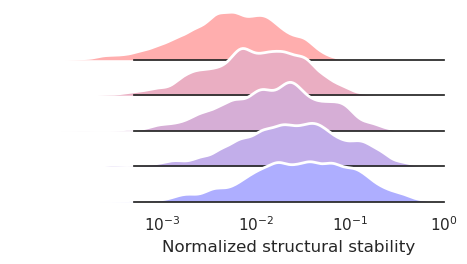

In [70]:
idx = 4
all_stabilities = []
for Nseq in [0, 1, 2, 3, 4]:
    all_stabilities.append(pickle.load(open(f"stabilities_Nseq={Nseq}_parameters={idx}.pkl", "rb")))

def generate_intermediate_colors(hex_color1, hex_color2, num_colors):
    # Convert hex codes to RGB format
    color1_rgb = tuple(int(hex_color1[i:i+2], 16) for i in (1, 3, 5))
    color2_rgb = tuple(int(hex_color2[i:i+2], 16) for i in (1, 3, 5))
    
    # Calculate the step size for each color component
    step_r = (color2_rgb[0] - color1_rgb[0]) / (num_colors + 1)
    step_g = (color2_rgb[1] - color1_rgb[1]) / (num_colors + 1)
    step_b = (color2_rgb[2] - color1_rgb[2]) / (num_colors + 1)
    
    # Generate intermediate colors
    intermediate_colors = [hex_color1]
    for i in range(1, num_colors + 1):
        r = int(color1_rgb[0] + step_r * i)
        g = int(color1_rgb[1] + step_g * i)
        b = int(color1_rgb[2] + step_b * i)
        intermediate_colors.append('#{:02x}{:02x}{:02x}'.format(r, g, b))
    intermediate_colors.append(hex_color2)
    
    return intermediate_colors

import seaborn as sns

n_cut = min([len(i) for i in all_stabilities])
plt.rcParams["figure.figsize"] = (6, 4)
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
colors = generate_intermediate_colors("#ffaeae", "#aeaeff", 3)
palette = sns.color_palette(colors, 5)
data = {"n_diaux":sum([[i for j in stabilities] for i, stabilities in enumerate(all_stabilities)], []), 
        "stability":sum([i for i in all_stabilities], [])}
data = pd.DataFrame(dict(n_diaux=data["n_diaux"], stability=data["stability"]))
grid = sns.FacetGrid(data, row="n_diaux", hue="n_diaux", aspect=8, height=0.5, palette=palette)
grid.map(sns.kdeplot, "stability", bw_adjust=.6, clip_on=False, fill=True, lw=0, alpha=1)
grid.map(sns.kdeplot, "stability", clip_on=False, color="w", lw=2, bw_adjust=.6)
grid.figure.subplots_adjust(hspace=-.3)
grid.set_titles("")
grid.set(yticks=[], ylabel="")
grid.despine(left=True)
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, ha="left", va="center", transform=ax.transAxes)
#     ax.text(1, .2, R-int(label), ha="right", va="center", transform=ax.transAxes)
# grid.map(label, "n_diaux")
plt.xticks(np.arange(0, -4, -1), ["10$^{"+str(i)+"}$" for i in np.arange(0, -4, -1)])
plt.xlim(-3.3, 0)
plt.xlabel("Normalized structural stability")
plt.savefig("figs5-5.pdf", bbox_inches="tight")

100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


(1.9, 3.1)

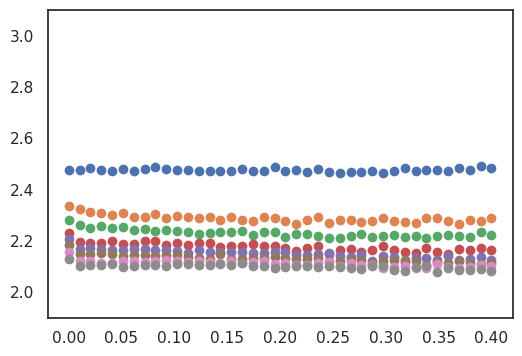

In [64]:
# selecting for initial lags
# first do a test for 1 pool size and many phi_pre; then just select a phi_pre and go for all pool sizes
n_rho=40

pool_size_list = [2, 10, 20, 50, 100, 200, 500, 1000]
for pool_size in tqdm(pool_size_list):
    init_lags = []
    rholist = np.linspace(1e-4, 0.4, n_rho)
    for rho in rholist:
        init_lags.append([])
        data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_size={pool_size}.pkl", "rb"))["data"]
        for i in data:
            init_lags[-1].extend(i[0][1]["ts"][1:1+len(i[0][1]["ids"])])
    plt.scatter(rholist, [np.mean(i) for i in init_lags])

plt.ylim(1.9, 3.1)

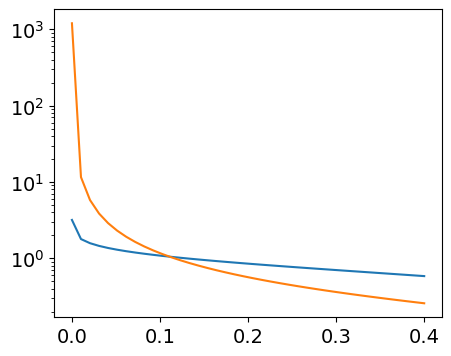

In [26]:
def TaufSeq(Rs, rho, tau0):
    nr = len(Rs)
    return tau0*log((1-(nr-1)*rho/nr)/(rho/nr))
def TaufSeq1(Rs, rho, tau0):
    nr = len(Rs)
    return tau0*( 1/(rho/nr) - (1/(1-(nr-1)*(rho/nr))))

Rs = [1, 1, 1, 1]
rholist = np.linspace(1e-4, 0.4, 40)
tau0 = 0.3
plt.plot(rholist, [TaufSeq(Rs, i, tau0) for i in rholist])
tau0 = 0.03
plt.plot(rholist, [TaufSeq1(Rs, i, tau0) for i in rholist])
plt.yscale("log")

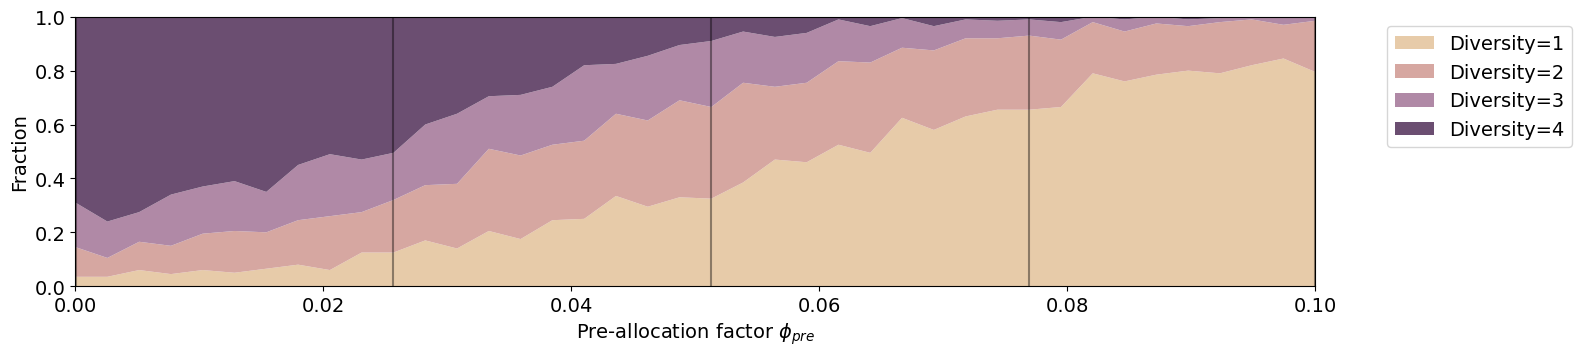

In [12]:
import pickle

pool_size = 100
n_rho=40

# head-to-head
# pool_size=2
# divs = []
# rholist = np.linspace(1e-4, 0.4, n_rho)
# for rho in rholist:
#     data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_size={pool_size}.pkl", "rb"))["data"]
#     div = [0, 0]
#     for i in data:
#         div[min(4, len(i[0][1]["ids"]))-1]+=1
#     divs.append(div)
# divs = np.array(divs)
# divs = divs/divs.sum(axis=1, keepdims=True)


# in community
pool_size = 100
divs = []
rholist = np.linspace(1e-4, 0.4, n_rho)
for rho in rholist:
    data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_size={pool_size}.pkl", "rb"))["data"]
    div = [0, 0, 0, 0]
    for i in data:
        div[min(4, len(i[0][1]["ids"]))-1]+=1
    divs.append(div)
divs_100 = np.array(divs)
divs = np.array(divs)
divs = divs/divs.sum(axis=1, keepdims=True)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create the main plot
fig, ax = plt.subplots(figsize=(16, 3.5))
bottom = np.zeros(len(divs)) 
# Plot each category's relative abundance
colors = ['#6B4E71', '#B089A6', '#D6A7A1', '#E7CBA9'][::-1]
ax.stackplot(rholist/4, divs.T, colors=colors, labels=[f'Diversity={i+1}' for i in range(divs.shape[1])])

# divs_2 = divs / data.sum(axis=1, keepdims=True)
# ax.plot(rholist/4, fracs_2, markerfacecolor='none', color="k", marker='o', markersize=7)
# ax.plot(rholist/4, fracs_100, markerfacecolor='none', color="#00CD6C", marker='o', markersize=7)
ax.set_xlabel("Pre-allocation factor $\\phi_{pre}$")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
# ax.set_ylabel("Fraction of sequential species\n(by #(species))")
# ax.axhline(1.0, color="k", alpha=0.4)
ax.set_ylim(0, 1)
ax.set_xlim(0, 0.1)
ax.set_ylabel("Fraction")
for i in [0, 10, 20, 30, 39]:
    ax.axvline(rholist[i]/4, color="k", alpha=0.4)
plt.savefig("figs6_1.pdf", bbox_inches="tight")
# plt.show()

0.747072255669511 0 2.5e-05
0.0
0.6288136104652976 10 0.02565961538461539
0.0
0.4775247157855631 20 0.05129423076923077
0.0
0.319076856981613 30 0.07692884615384615
0.0
0.1715675952079325 39 0.1
0.0


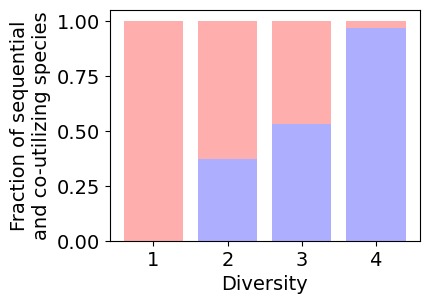

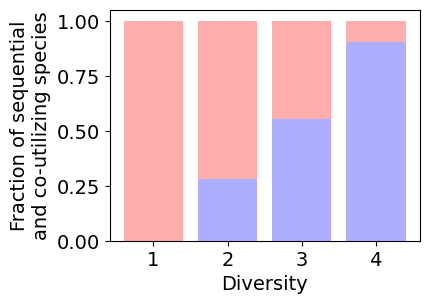

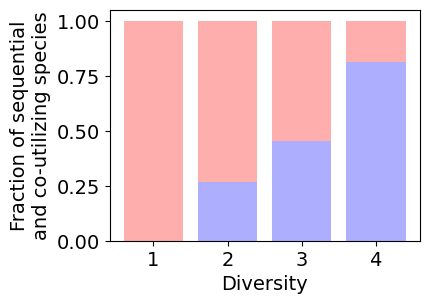

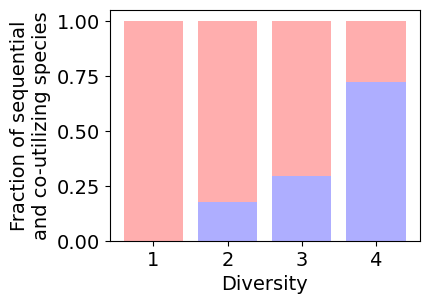

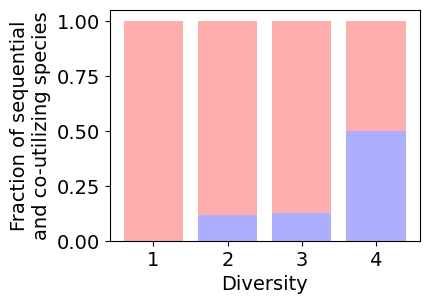

In [10]:
# look at stratification of a datapoint
pool_size=100
n_rho = 40
stratified = []
rholist = np.linspace(1e-4, 0.4, n_rho)
for rho in rholist:
    data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_size={pool_size}.pkl", "rb"))["data"]
    stratified.append([0.5, 0.5, 0.5, 0.5])
    for div in np.arange(1, 5):
        fracs_ = []
        for i in data:
            ids = i[0][1]["ids"]
            bs = i[0][1]["bs"][-1]
            if(len(ids)==div):
                fracs_.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
        if(len(fracs_)>0):
            stratified[-1][div-1] = np.mean(fracs_)
for idx, i in enumerate([0, 10, 20, 30, 39]):
    if(1):
        print(fracs[i], i, rholist[i]/4)
        plt.figure(figsize=(4, 3))
        plt.bar(np.arange(1, 5), [1, 1, 1, 1], color="#ffaeae")
        plt.bar(np.arange(1, 5), stratified[i], color = "#aeaeff")
        print(stratified[i][0])
        plt.xticks(np.arange(1, 5))
        # plt.axhline(frac_diaux[i], color='k')
        plt.xlabel("Diversity")
        plt.ylabel("Fraction of sequential\nand co-utilizing species")
        plt.savefig(f"figs6-{idx+2}.pdf", bbox_inches="tight")

In [13]:
rholist[14]/4

0.03591346153846154